# Notebook 4 - Modelagens
    

## Ambiente

In [2]:
import numpy as np
import pandas as pd
import random
import shap 

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score, plot_confusion_matrix
from lightgbm import LGBMRegressor, LGBMClassifier, plot_tree
from tqdm import tqdm

## Dados

In [ ]:
Xy = pd.read_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Xy_Voxels_871.parquet")
Xy = Xy.rename(columns={'thickness':'curv', 'curv':'thickness'})

In [3]:
main = ['participant', 'thickness', 'age', 'structure']

geometrics =['area', 'curv', 'sulc']

atlas = ['atlasDF', 'atlasEcono']

basic =['hemisphere', 'sex', 'handedness']

basic_dummies =['hemisphere_left', 'sex_FEMALE']

structure_dummies =['structure_FA', 'structure_FB', 'structure_FC', 'structure_FCBm',
                    'structure_FD', 'structure_FDT', 'structure_FDdelta', 'structure_FE',
                    'structure_FF', 'structure_FG', 'structure_FH', 'structure_FJK',
                    'structure_IA', 'structure_IB', 'structure_LA1', 'structure_LA2',
                    'structure_LC1', 'structure_LC2', 'structure_LC3', 'structure_LD',
                    'structure_OA', 'structure_OB', 'structure_OC', 'structure_PA',
                    'structure_PB', 'structure_PC', 'structure_PD', 'structure_PE',
                    'structure_PF', 'structure_PG', 'structure_PH', 'structure_TA',
                    'structure_TB', 'structure_TC', 'structure_TD', 'structure_TE',
                    'structure_TF', 'structure_TG']

bb1 =['ve_1','ve_2', 've_3', 've_4', 've_5', 've_6']

bb2 =['ve1_age', 've2_age', 've3_age','ve4_age', 've5_age', 've6_age']

bb3 =['bigbrain_layer_1','bigbrain_layer_2', 'bigbrain_layer_3',
      'bigbrain_layer_4','bigbrain_layer_5', 'bigbrain_layer_6']

bb4 =['bblayer1_age', 'bblayer2_age', 'bblayer3_age', 
      'bblayer4_age','bblayer5_age', 'bblayer6_age'] 


In [ ]:
Xy[bb4] = Xy[bb4].applymap(lambda x: np.round(x,3))
Xy[bb4]

## Modelos: Preprocessing, Treino, Peformance e Explicabilidade 

In [4]:
def Preprocessing(Xy, sample_size=50):
    
    ##### Criando sub amostra com N participantes

    participants_list0 = Xy.participant.unique()
    participants_test0 = random.sample(list(participants_list0), sample_size)
    sample = Xy[Xy.participant.isin(participants_test0)]

    ##### Dropando voxels thickness are zeros

    sample = sample[sample['thickness'].astype(bool)]

    ##### Separando Treino e Teste 20% 

    n_test = int(len(participants_test0)*0.2)
    participants_test = random.sample(list(participants_test0), n_test)
    Xy_test = sample[sample.participant.isin(participants_test)]
    Xy_train = sample[~sample.participant.isin(participants_test)]

    ##### Criando Base a Nivel de Voxel
   
    Xy_train_vo = Xy_train#.drop(columns = ['participant', 'structure']) 
    Xy_test_vo = Xy_test#.drop(columns = ['participant', 'structure']) 
    
    ##### Criando Base Agrupada

    # treino
    list_g = []
    for i, participant in enumerate(Xy_train.participant.unique()):
        df_g = Xy_train[Xy_train.participant == participant].groupby(['structure']).mean()
        list_g.append(df_g)

    Xy_train_gr = pd.concat(list_g) 
    Xy_train_gr = Xy_train_gr.reset_index(drop=True)

    # test
    list_g = []
    for i, participant in enumerate(Xy_test.participant.unique()):
        df_g = Xy_test[Xy_test.participant == participant].groupby(['structure']).mean()
        list_g.append(df_g)

    Xy_test_gr = pd.concat(list_g) 
    Xy_test_gr = Xy_test_gr.reset_index(drop=True)

    list_Xy = [Xy_train_vo, Xy_test_vo, Xy_train_gr, Xy_test_gr]
    
    return list_Xy

In [5]:
sample_size = 50 #200 é muito
list_Xy = Preprocessing(Xy, sample_size=sample_size)

In [6]:
class Model:
    
    def __init__(self,
                 list_Xy,
                 target = 'thickness',
                 categorical_target = False,
                 features = ['age'] + geometrics + bb3 , 
                 categorical_feature = [],
                 voxel = False,
                 structure_modeling = False):
        
        self.list_Xy = list_Xy
        self.target = target
        self.categorical_target = categorical_target
        self.features = features
        self.categorical_feature = categorical_feature
        self.voxel = voxel
        self.structure_modeling = structure_modeling
        
        Xy_train_vo, Xy_test_vo, Xy_train_gr, Xy_test_gr = list_Xy
        
        if categorical_target:
            model_name = 'LGBMClassifier'
        else:
            model_name = 'LGBMRegressor'
        if voxel:
            model_type = 'Voxels'
            len_instances = len(Xy_train_vo)+len(Xy_test_vo)
        else:
            model_type = 'Regioes Corticais'
            len_instances = len(Xy_train_gr)+len(Xy_test_gr)


        self.resume = '- Target: '+target+'\n\n'+'- Features: '+ ', '.join(map(str, features)) +'\n\n'+'- Nivel: '+ model_type +'\n\n'+'- Algoritmo: '+model_name+'\n\n'+'- Base de Dados: '+ str(sample_size)+ ' individuos que geram '+ str(len_instances)+' '+model_type+' - 80% treino e 20% teste\n\n'
    
        ################### X y split

        X_train_vo = Xy_train_vo.drop(columns = [target]) 
        X_test_vo = Xy_test_vo.drop(columns = [target]) 
        y_train_vo = Xy_train_vo[target]
        y_test_vo = Xy_test_vo[target]

        X_train_gr = Xy_train_gr.drop(columns=[target])
        y_train_gr = Xy_train_gr[target]
        X_test_gr = Xy_test_gr.drop(columns=[target])
        y_test_gr = Xy_test_gr[target]   

        ##################### voxel or regions

        if voxel:
            model_type = 'Voxels'
            ide = 0
            self.alpha_scatter = 0.1
            X_train = X_train_vo[features + ['atlasEcono']]
            X_test = X_test_vo[features+ ['atlasEcono']]
            y_train = y_train_vo
            y_test = y_test_vo
        else:
            model_type = 'Estruturas Corticais'
            ide = 2
            self.alpha_scatter = 0.8
            X_train = X_train_gr[features+ ['atlasEcono']]
            X_test = X_test_gr[features+ ['atlasEcono']]
            y_train = y_train_gr
            y_test = y_test_gr

        #if structure_selection != 0:
         #   index_train = X_train_vo.atlasEcono == self.structure_selection
          #  index_test = X_test_vo.atlasEcono == self.structure_selection
           # X_train = X_train[index_train]
            #X_test = X_test[index_test]
            #y_train = y_train[index_train]
            #y_test = y_test[index_test]

        ################### model

        if categorical_target:

            # transformation data
            y_train = y_train.astype(int)
            y_test = y_test.astype(int)

            # train
            model = LGBMClassifier(n_jobs=30, categorical_feature = categorical_feature).fit(X_train[features], y_train)
        
        else:

            # train
            model = LGBMRegressor(n_jobs=30, categorical_feature = categorical_feature).fit(X_train[features], y_train)
            
        if structure_modeling:
            
            # train model structures
            models = []
            structures = np.sort(list_Xy[ide].atlasEcono.unique())
            for i in structures:
                X_train_i = X_train[X_train.atlasEcono == i]
                y_train_i = y_train[X_train.atlasEcono == i]
                models.append([i,LGBMRegressor(n_jobs=30, categorical_feature = categorical_feature).fit(X_train_i, y_train_i)])
            models = pd.DataFrame(models)
            self.models = models
            
        ################### 
        
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        self.Xy_test_vo = Xy_test_vo
    
    
    def _test_structure(self):

        X_pred = {}
        for i in list(m1.X_test.index):
        
            strutures = m1.X_test.loc[i].atlasEcono
            n = m1.models[m1.models[0]==strutures][1].index.values[0]
            X_test = m1.X_test.loc[i].values
            y_pred[i] = m1.models[m1.models[0]==strutures][1][n].predict([X_test])
            
        y_pred = pd.Series(y_pred)
        return X_pred
        
             
    def test(self, output = 'score'): #score, vizualization, score_segmented

        if self.categorical_target:

            # classification

            if output == 'vizualization':
                y_pred = self.model.predict(self.X_test[self.features])
                f1 = round(f1_score(self.y_test, y_pred, average='micro'),2)
                fig, ax = plt.subplots(figsize=(12, 12))
                plt.title('F1 = ' + str(f1))
                plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap=plt.cm.Blues, ax=ax)
                plt.show()

            if output == 'score':
                y_pred = self.model.predict(self.X_test[self.features])
                f1 = round(f1_score(self.y_test, y_pred, average='micro'),2)
                return f1

            else:
                if self.voxel:
                    t = 1
                else:
                    t = 3

                score_segmented = []
                econo_list = np.sort(self.list_Xy[t].atlasEcono.unique())
                
                for i in econo_list:
                    y_test = self.list_Xy[t][self.list_Xy[t].atlasEcono==i][self.target]
                    X_test = self.list_Xy[t][self.list_Xy[t].atlasEcono==i][self.features]
                    y_pred = self.model.predict(X_test[self.features])
                    f1 = round(f1_score(self.y_test, y_pred, average='micro'),2)
                    score_segmented.append([i,f1])
                return score_segmented
            

        else:

            # regression            
            if self.structure_modeling: 
                y_pred = self._test_structure()
            else:
                y_pred = self.model.predict(self.X_test[self.features])
            
            if output == 'vizualization':
                r2 = round(r2_score(self.y_test, y_pred),2)
                plt.figure(figsize=[8,8])
                plt.title('R2 = '+str(r2))
                plt.xlabel("true")
                plt.ylabel("prediction")
                plt.scatter(self.y_test,y_pred,alpha = self.alpha_scatter)
                plt.show()
                
            if output == 'score':
                r2 = round(r2_score(self.y_test, y_pred),2)
                return r2
            
            else:
                if self.voxel:
                    t = 1
                else:
                    t = 3

                score_segmented = []
                econo_list = np.sort(self.list_Xy[t].atlasEcono.unique())
                
                for i in econo_list:
                    y_test = self.list_Xy[t][self.list_Xy[t].atlasEcono==i][self.target]
                    X_test = self.list_Xy[t][self.list_Xy[t].atlasEcono==i][self.features]
                    
                    if self.structure_modeling: 
                        y_pred = self._test_structure()
                    else:
                        y_pred = self.model.predict(X_test[self.features])
                                        
                    r2 = round(r2_score(y_test, y_pred),2)
                    score_segmented.append([i,r2])   
                return score_segmented
            
    
    def explicability(self):
    
        shap_values = shap.TreeExplainer(self.model).shap_values(self.X_test[self.features])
        shap.summary_plot(shap_values, self.X_test[self.features], plot_type="bar")
        plt.figure()
        shap.summary_plot(shap_values, self.X_test[self.features])
        
        plot_tree(self.model, figsize = (30,30), show_info = ['split_gain','internal_value','internal_count','data_percentage','leaf_count',])
        
        
    def test_group(self):
         
        Xy_av = self.Xy_test_vo[['participant','structure','thickness']]
        Xy_av['thickness_pred'] = self.model.predict(self.X_test[self.features])

        list_groupby = []
        for i, participant in enumerate(Xy_av.participant.unique()):
            df_av = Xy_av[Xy_av.participant == participant].groupby(['structure']).mean()
            df_av['participant_i'] = i
            df_av['participant'] = participant
            list_groupby.append(df_av)
        Xy_groupby = pd.concat(list_groupby)   

        plt.figure(figsize=[8,8])
        plt.title('Modelo com Voxel com Agrupamento na Avaliação: R2 = '+str(round(r2_score(Xy_groupby.thickness, Xy_groupby.thickness_pred),2)))
        plt.scatter(Xy_groupby.thickness, 
                    Xy_groupby.thickness_pred)
        plt.show()


In [7]:
m1 = Model(list_Xy, structure_modeling=True)
m1.test('vizualization')

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


UnboundLocalError: local variable 'y_pred' referenced before assignment

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Progress: 100%|██████████| 380/380 [00:00<00:00, 620.14it/s]


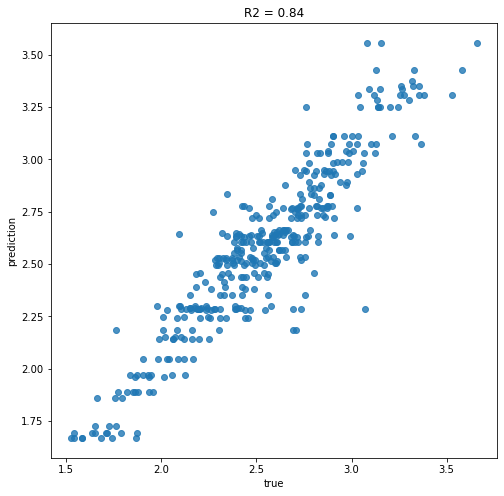

In [25]:
m1 = Model(list_Xy, structure_modeling=True)

y_pred = {}
for i in tqdm(list(m1.X_test.index), total = len(m1.X_test), desc ="Progress"):

    strutures = m1.X_test.loc[i].atlasEcono
    n = m1.models[m1.models[0]==strutures][1].index.values[0]
    X_test = m1.X_test.loc[i].values
    y_pred[i] = m1.models[m1.models[0]==strutures][1][n].predict([X_test])

y_pred = pd.Series(y_pred)
r2 = round(r2_score(m1.y_test, y_pred),2)
plt.figure(figsize=[8,8])
plt.title('R2 = '+str(r2))
plt.xlabel("true")
plt.ylabel("prediction")
plt.scatter(m1.y_test,y_pred,alpha = m1.alpha_scatter)
plt.show()

In [ ]:
r2 = round(r2_score(m.y_test, y_pred),2)
plt.figure(figsize=[8,8])
plt.title('R2 = '+str(r2))
plt.xlabel("true")
plt.ylabel("prediction")
plt.scatter(m.y_test, y_pred, alpha = m.alpha_scatter)
plt.show()

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


- Target: thickness

- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6

- Nivel: Regioes Corticais

- Algoritmo: LGBMRegressor

- Base de Dados: 50 individuos que geram 1900 Regioes Corticais - 80% treino e 20% teste




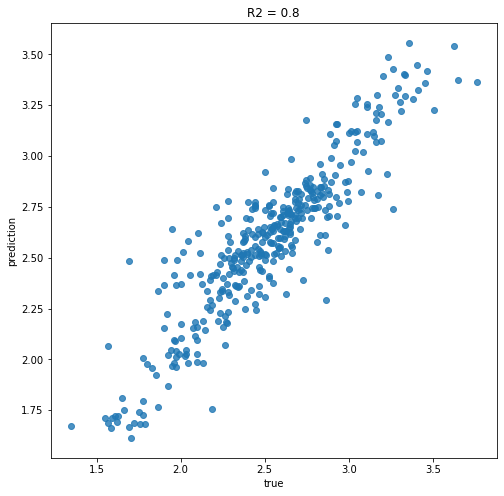

[[2.0, -0.14],
 [3.0, -0.26],
 [4.0, -0.87],
 [5.0, 0.56],
 [6.0, -1.0],
 [7.0, -2.11],
 [8.0, -0.32],
 [9.0, -0.36],
 [10.0, 0.57],
 [11.0, -1.56],
 [12.0, -0.94],
 [13.0, -0.09],
 [18.0, -0.41],
 [19.0, 0.51],
 [20.0, 0.19],
 [21.0, -0.75],
 [22.0, -0.08],
 [23.0, 0.52],
 [24.0, -1.62],
 [25.0, 0.21],
 [27.0, -0.26],
 [28.0, -0.46],
 [29.0, 0.09],
 [30.0, -0.38],
 [31.0, 0.04],
 [32.0, -0.33],
 [33.0, -0.41],
 [34.0, -0.58],
 [35.0, -0.35],
 [36.0, -0.91],
 [37.0, -0.12],
 [38.0, 0.18],
 [39.0, 0.11],
 [40.0, -0.66],
 [41.0, -0.08],
 [42.0, 0.34],
 [43.0, -0.04],
 [44.0, 0.22]]

In [8]:
m = Model(list_Xy)
print(m.resume)
m.test('vizualization')

In [ ]:
#m1 = Model(list_Xy)
print(m1.resume)
m1.test('vizualization')
m1.test('score_segmented')

In [ ]:
if m.voxel:
    t = 1
else:
    t = 3

score_segmented = []
econo_list = np.sort(m.list_Xy[t].atlasEcono.unique())

for i in econo_list:
    
    y_test = m.list_Xy[t][m.list_Xy[t].atlasEcono==i][m.target]
    X_test = m.list_Xy[t][m.list_Xy[t].atlasEcono==i][m.features]
    y_pred = m.model.predict(X_test)
    
    r2 = round(r2_score(y_test, y_pred),2)
    plt.figure(figsize=[8,8])
    plt.title('R2 = '+str(r2))
    plt.xlabel("true")
    plt.ylabel("prediction")
    plt.scatter(y_test,y_pred,alpha = m.alpha_scatter)
    plt.show()
    
    score_segmented.append([i,r2])
score_segmented

In [ ]:
model(list_Xy,
     features = ['age']+[bb3[3]]
     )

In [ ]:
model(list_Xy,
      features = [atlas[0]] + geometrics + ['age'] , 
      categorical_feature = [0])

In [ ]:
model(list_Xy,
      target = atlas[0],
      features =  bb3 , 
      categorical_target = True,
      explicability = True,
      voxel = True
     )

In [ ]:
model(list_Xy,
      target = atlas[1],
      features =  bb3 , 
      categorical_target = True,
      explicability = True,
      voxel = True
     ) # colocar proporcao/porcentagem nos numeros

In [ ]:
atlas

In [ ]:
model(list_Xy,
      target = 'age',
      features = atlas + basic_dummies + geometrics + bb3 , 
      categorical_feature = [0,1,2,3],
      explicability = False
     ) # pivotar para fazer esse modelo funcionar, cada instancia tem que ser um individuo e as regioes viram features

### Matrix de Correlacao variaveis continuas

In [ ]:
df = list_Xy[2][['thickness','age']+ geometrics + bb1+ bb3]

f = plt.figure(figsize=(12, 12))
plt.matshow(df.corr(method = 'spearman'), fignum=f.number) 

plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=9)
plt.title('Correlation Matriz', fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)

#for (x, y), value in np.ndenumerate(df):
#    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
    
plt.show()